In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ..

C:\Users\Dimitri\workspaces\opensource\quantum-machine-learning


C:\Users\Dimitri\anaconda3\envs\quantum-machine-learning\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
import numpy as np
import matplotlib.pyplot as plt

from penny.classifier import BinaryClassifier, ClassifierContext
from penny.torch_classifier import *
from penny.models import *
from utils.embeddings import *
from utils.reporting import *
from utils.preprocess import *

In [6]:
random_seed = 123124
np.random.seed(random_seed)

In [10]:
# Load the wine dataset 
wine_features, wine_labels = load_wine(return_X_y=True)
wine_features.shape

(178, 13)

In [11]:
scaler = StandardScaler()
wine_scaled_features = scaler.fit_transform(wine_features)
y = wine_labels
y_hot = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1, 1))
X_scaled, y, y_hot = tensorize((wine_scaled_features, y, y_hot))
X_train, X_test, y_train, y_test, y_train_hot, y_test_hot = train_test_split(X_scaled, y, y_hot,
                                                                                 shuffle=True, test_size=0.2,
                                                                                 random_state=random_seed)

In [12]:
num_features = 5

pca = PCA(n_components=num_features)
X_train_pca = pca.fit_transform(X_train)
X_train_scaled = scale_for_angle_encoding(X_train_pca)
X_test_pca = pca.transform(X_test)
X_test_scaled = scale_for_angle_encoding(X_test_pca)

In [13]:
qubits = 5
num_classes = 3

angle_tracker = HistoryTracker(X_train_scaled, y_train)
classifier = IterationTorchClassifier(
        model=MultiClassQMLModel(qubits, num_classes=num_classes),
        num_classes=num_classes,
        weights_shape=(3, qubits, 3),
        iterations=100,
        report_fn=angle_tracker
    )

In [14]:
classifier.fit(X_train_scaled, y_train_hot)

Iter:    10 | Accuracy: 0.6267606 
Iter:    20 | Accuracy: 0.6408451 
Iter:    30 | Accuracy: 0.6126761 
Iter:    40 | Accuracy: 0.8943662 
Iter:    50 | Accuracy: 0.8309859 
Iter:    60 | Accuracy: 0.8028169 
Iter:    70 | Accuracy: 0.8943662 
Iter:    80 | Accuracy: 0.6478873 
Iter:    90 | Accuracy: 0.7676056 
Iter:   100 | Accuracy: 0.9154930 


In [15]:
predictions_test = classifier.predict(X_test_scaled)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        10
         1.0       0.93      0.70      0.80        20
         2.0       0.50      0.83      0.62         6

    accuracy                           0.78        36
   macro avg       0.75      0.81      0.76        36
weighted avg       0.83      0.78      0.79        36



In [16]:
X_train_stereo = np.apply_along_axis(inverse_stereographic_projection, 1, X_train)
X_test_stereo = np.apply_along_axis(inverse_stereographic_projection, 1, X_test)
X_train_stereo, X_test_stereo = tensorize((X_train_stereo, X_test_stereo))

In [17]:
stereo_tracker = HistoryTracker(X_train_stereo, y_train)
qubits = 5
num_classes = 3

model = MultiClassQMLModel(qubits, num_classes=num_classes, embedding_fn=amplitude_embedding_fn)

classifier = IterationTorchClassifier(
        model=model,
        num_classes=num_classes,
        weights_shape=(3, qubits, 3),
        iterations=100,
        report_fn=stereo_tracker)

In [18]:
classifier.fit(X_train_stereo, y_train_hot)

Iter:    10 | Accuracy: 0.7183099 
Iter:    20 | Accuracy: 0.8802817 
Iter:    30 | Accuracy: 0.8521127 
Iter:    40 | Accuracy: 0.8661972 
Iter:    50 | Accuracy: 0.6760563 
Iter:    60 | Accuracy: 0.6267606 
Iter:    70 | Accuracy: 0.7887324 
Iter:    80 | Accuracy: 0.7676056 
Iter:    90 | Accuracy: 0.9225352 
Iter:   100 | Accuracy: 0.9295775 


In [19]:
predictions_test = classifier.predict(X_test_stereo)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       1.00      0.75      0.86        20
         2.0       0.67      1.00      0.80         6

    accuracy                           0.86        36
   macro avg       0.83      0.92      0.86        36
weighted avg       0.90      0.86      0.86        36



C:\Users\Dimitri\AppData\Local\Temp\ipykernel_37684\4073089542.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<Axes: title={'center': 'Performance comparison for Embeddings'}>

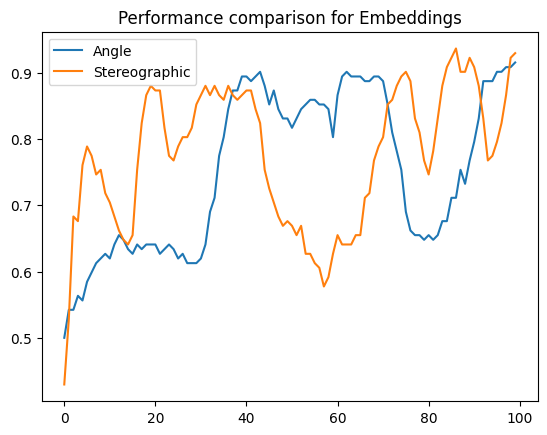

In [20]:
import pandas as pd

df = pd.DataFrame(list(zip(angle_tracker.history, stereo_tracker.history)), 
                  columns=['Angle', 'Stereographic'])
df.plot(title='Performance comparison for Embeddings')